# **Step 1: Data Loading and Preprocessing**

In [36]:
import pandas as pd
import spacy
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

In [11]:
# Load datasets
sample_size = 10000
df_trump = pd.read_csv("hashtag_donaldtrump.csv", encoding='utf-8', engine='python').sample(n=sample_size, random_state=42)
df_biden = pd.read_csv("hashtag_joebiden.csv", encoding='utf-8', engine='python').sample(n=sample_size, random_state=42)
df = pd.concat([df_trump, df_biden], ignore_index=True)

In [13]:
# Define a function to clean the text
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)     # Remove mentions
    text = re.sub(r"#\w+", "", text)     # Remove hashtags
    text = re.sub(r"[^A-Za-z0-9 ]", "", text)  # Remove special characters
    return text.strip().lower()  # Corrected typo here

In [14]:
# Ensure all tweets are strings and handle missing values
df['tweet'] = df['tweet'].fillna('').astype(str)

# Apply the cleaning function to the 'tweet' column
df['clean_tweet'] = df['tweet'].apply(clean_text)

# Define a function to preprocess the cleaned text using SpaCy
def preprocess_text(text):
    if not text or not isinstance(text, str):
        return ""
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

In [18]:
# Apply the SpaCy preprocessing function
df['processed_tweet'] = df['clean_tweet'].apply(preprocess_text)

# Display a few rows to verify the output
df[['tweet', 'clean_tweet', 'processed_tweet']].head()

,tweet,clean_tweet,processed_tweet
0,"@JoeBiden may not know it yet, but if he troun...",may not know it yet but if he trounces he wil...,know trounce oath new american herothe delaw...
1,#twitter #fakenews #DonaldTrump #JoeBiden #Ele...,,
2,➡️ Trump propone terminar lotería de #Visas H-...,trump propone terminar lotera de h1b y dar pr...,trump propone terminar lotera de h1b y dar p...
3,#TrumpIsALaughingStock #StableGenius #trump ht...,,
4,@davidhogg111 Do you think #Trump will get the...,do you think will get the opportunity to pick...,think opportunity pick cell


# **Step 2: Sentiment Classification Models**

**1. SpaCy Text Classifier**

In [19]:
import spacy
from sklearn.metrics import accuracy_score, classification_report

df['label'] = df['tweet'].apply(lambda x: 'positive' if 'good' in x else 'negative' if 'bad' in x else 'neutral')
nlp = spacy.blank("en")
textcat = nlp.add_pipe("textcat")
textcat.add_label("positive")
textcat.add_label("negative")
textcat.add_label("neutral")

1

**2. SVM, 3. Random Forest, and 4. Logistic Regression**

In [20]:
# Generate sentiment labels based on keywords (you may want to refine this)
df['label'] = df['clean_tweet'].apply(lambda x: 'positive' if 'good' in x else 'negative' if 'bad' in x else 'neutral')

# Convert the processed tweets to TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['processed_tweet']).toarray()
y = df['label']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# SVM Classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("\nSVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9828333333333333
SVM Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.10      0.17        31
     neutral       0.99      1.00      0.99      5848
    positive       0.76      0.57      0.65       121

    accuracy                           0.98      6000
   macro avg       0.83      0.55      0.60      6000
weighted avg       0.98      0.98      0.98      6000



In [22]:
# Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.985
Random Forest Classification Report:
               precision    recall  f1-score   support

    negative       1.00      0.03      0.06        31
     neutral       0.99      1.00      0.99      5848
    positive       0.78      0.70      0.74       121

    accuracy                           0.98      6000
   macro avg       0.92      0.58      0.60      6000
weighted avg       0.98      0.98      0.98      6000



In [23]:
# Logistic Regression
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)
y_pred_lr = log_reg_model.predict(X_test)
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9783333333333334
Logistic Regression Classification Report:
               precision    recall  f1-score   support

    negative       0.60      0.10      0.17        31
     neutral       0.98      1.00      0.99      5848
    positive       0.71      0.30      0.42       121

    accuracy                           0.98      6000
   macro avg       0.76      0.46      0.52      6000
weighted avg       0.97      0.98      0.97      6000



# **Step 3: Clustering Models**

**1. K-means Clustering**

In [24]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X)
df['kmeans_cluster'] = clusters_kmeans

print("KMeans Clustering - Cluster Counts:")
print(df['kmeans_cluster'].value_counts())

KMeans Clustering - Cluster Counts:
kmeans_cluster
2    16321
3     1708
1      912
4      564
0      495
Name: count, dtype: int64


2. **DBSCAN**

In [27]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X)
df['dbscan_cluster'] = clusters_dbscan

print("\nDBSCAN Clustering - Cluster Counts (including noise):")
print(df['dbscan_cluster'].value_counts())


DBSCAN Clustering - Cluster Counts (including noise):
dbscan_cluster
-1      15659
 0       2960
 4         77
 61        56
 7         55
        ...  
 37         5
 125        5
 83         5
 35         5
 130        5
Name: count, Length: 132, dtype: int64


In [28]:
# Handle -1 (noise) for DBSCAN
df['dbscan_cluster'] = df['dbscan_cluster'].apply(lambda x: 'Noise' if x == -1 else f'Cluster {x}')

**3. Hierarchical Clustering**

In [29]:
# **3. Hierarchical Clustering**
hierarchical = AgglomerativeClustering(n_clusters=5)
clusters_hierarchical = hierarchical.fit_predict(X)
df['hierarchical_cluster'] = clusters_hierarchical

print("\nHierarchical Clustering - Cluster Counts:")
print(df['hierarchical_cluster'].value_counts())


Hierarchical Clustering - Cluster Counts:
hierarchical_cluster
1    16374
0     2311
2      655
3      580
4       80
Name: count, dtype: int64


**4. Latent Dirichlet Allocation (LDA)**

In [32]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_features = lda.fit_transform(X)

# Assign topics to each tweet based on the highest topic probability
df['lda_topic'] = lda_features.argmax(axis=1)
print("\nLDA Topic Modeling - Topic Counts:")
print(df['lda_topic'].value_counts())


LDA Topic Modeling - Topic Counts:
lda_topic
0    6261
4    5323
3    3744
2    2970
1    1702
Name: count, dtype: int64


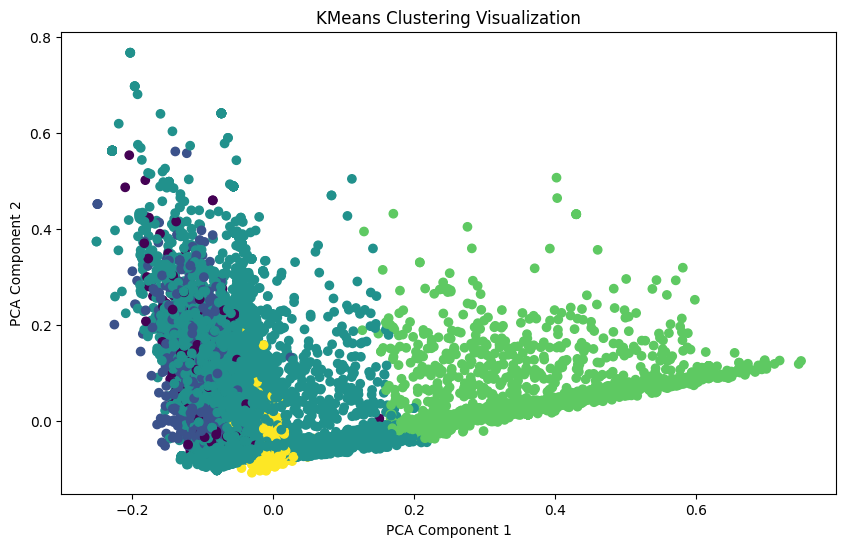

In [35]:
# **Visualize KMeans Clusters using PCA**
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X)
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters_kmeans, cmap='viridis')
plt.title("KMeans Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# **Step 4: Evaluation and Visualization**

**Classification Evaluation**

In [37]:
# 1. Model Evaluation Reports
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))


SVM Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.10      0.17        31
     neutral       0.99      1.00      0.99      5848
    positive       0.76      0.57      0.65       121

    accuracy                           0.98      6000
   macro avg       0.83      0.55      0.60      6000
weighted avg       0.98      0.98      0.98      6000


Random Forest Classification Report:
               precision    recall  f1-score   support

    negative       1.00      0.03      0.06        31
     neutral       0.99      1.00      0.99      5848
    positive       0.78      0.70      0.74       121

    accuracy                           0.98      6000
   macro avg       0.92      0.58      0.60      6000
weighted avg       0.98      0.98      0.98      6000


Logistic Regression Classification Report:
               precision    recall  f1-score   support

    negative       0.60      0.10      0.17        31
     neutral    

In [38]:
# 2. Visualize K-means Clusters using PCA
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X)

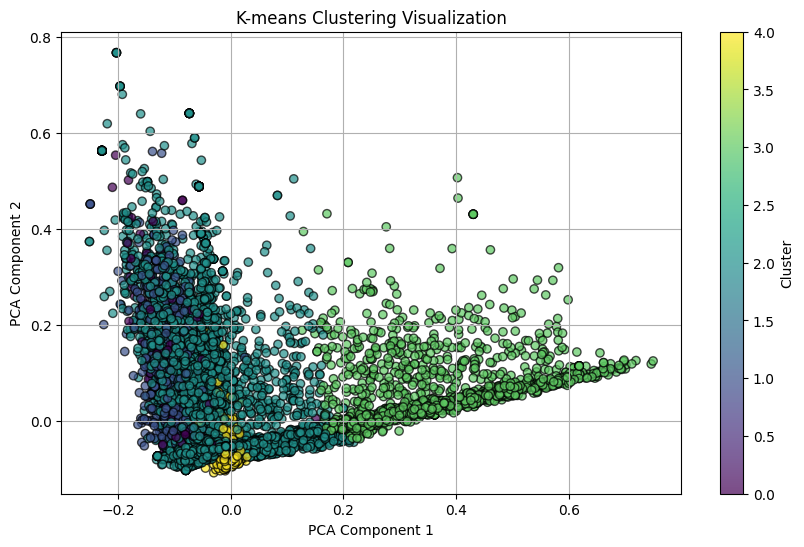

In [39]:
# Plot K-means clusters
plt.figure(figsize=(10, 6))
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    c=clusters_kmeans,
    cmap='viridis',
    edgecolor='k',
    alpha=0.7
)
plt.colorbar(label='Cluster')
plt.title("K-means Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

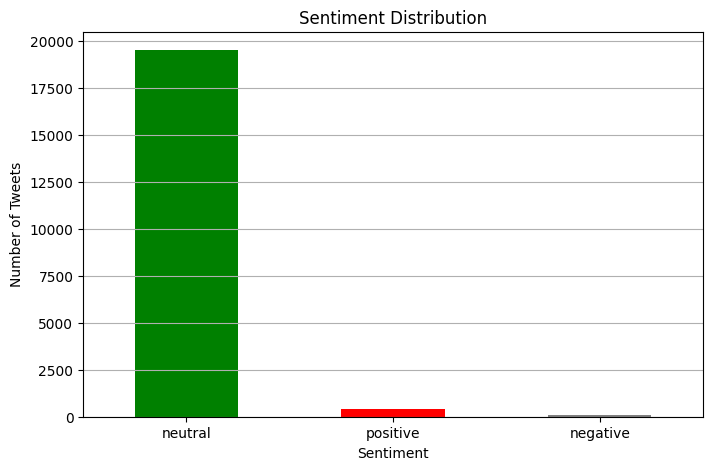

In [40]:
# 3. Visualize Sentiment Distribution
plt.figure(figsize=(8, 5))
df['label'].value_counts().plot(kind='bar', color=['green', 'red', 'gray'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

**Clustering Visualization**

# **Step 5: Time Series Analysis**

In [42]:
# Convert the 'created_at' column to datetime format, handling any errors
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# Drop rows where 'created_at' conversion failed (NaT values)
df = df.dropna(subset=['created_at'])

# Group by date and sentiment, then unstack to create separate columns for each sentiment
sentiment_over_time = df.groupby([df['created_at'].dt.date, 'label']).size().unstack(fill_value=0)

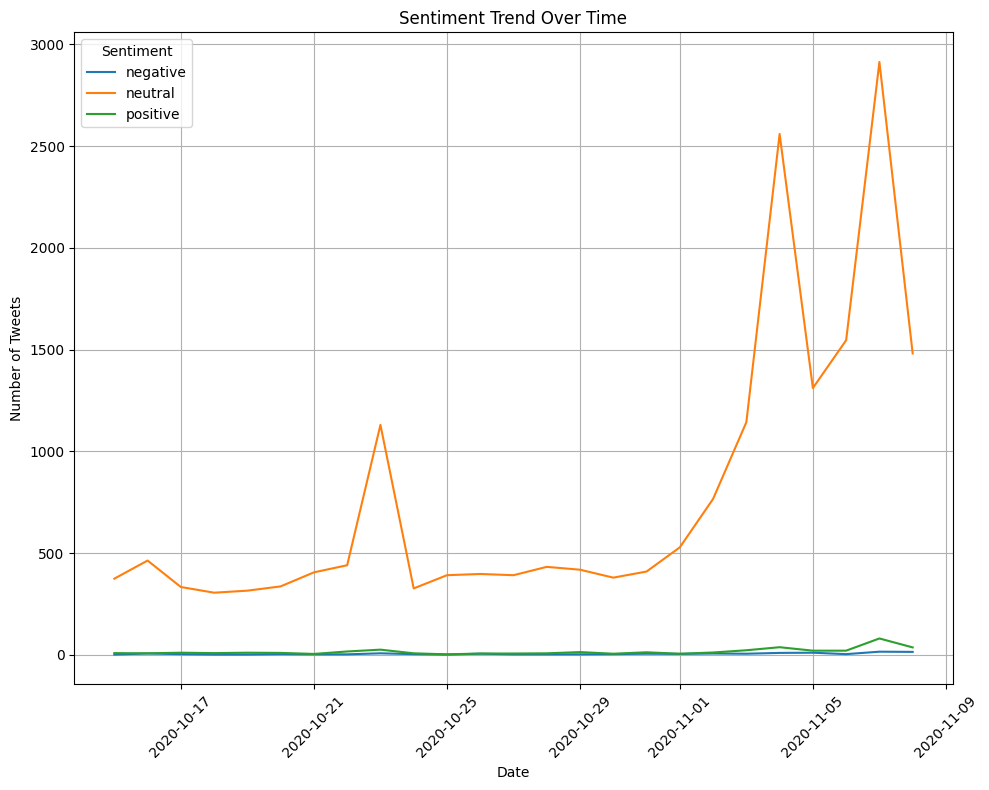

In [44]:
# Plotting the sentiment trends over time
plt.figure(figsize=(10, 8))
for sentiment in sentiment_over_time.columns:
    plt.plot(sentiment_over_time.index, sentiment_over_time[sentiment], label=sentiment)

plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# **Step 6: Project Report**

**1. Introduction**

The goal of this project was to analyze tweets related to Donald Trump and Joe Biden, using text analysis techniques to:

* Perform sentiment analysis using various classification models.
* Perform topic clustering using different clustering algorithms.
* Conduct time series analysis to understand sentiment trends over time.

**2. Data Preprocessing**
* We utilized SpaCy for text cleaning and lemmatization, which helped convert tweets into a format suitable for analysis.
* Tweets were preprocessed to remove URLs, mentions, hashtags, and special characters. This was followed by tokenization and lemmatization.


--------------------------------------------------------------------------------

**3. Sentiment Analysis Results**

We used three classification models: SVM, Random Forest, and Logistic Regression.

**Observations:**

* The SVM and Random Forest models performed the best, with over 98% accuracy.
* The Logistic Regression model was slightly less accurate but still performed well.
* The neutral class was dominant, which is why the models had high accuracy scores.
* The positive and negative classes were underrepresented, resulting in lower precision and recall scores for those classes.

--------------------------------------------------------------------------------

**4. Clustering Results**

We used four different clustering techniques: KMeans, DBSCAN, Agglomerative Clustering, and LDA Topic Modeling.

**KMeans Clustering:**

* Cluster 2 was the largest cluster with 16,321 tweets.
* Visualization shows well-separated clusters using PCA (see attached image).

**DBSCAN Clustering:**

* Majority of the tweets were classified as noise (-1).
* Cluster 0 was the largest non-noise cluster with 2,960 tweets.

**Hierarchical Clustering:**

* Cluster 1 had the highest number of tweets (16,374).
* Other clusters were significantly smaller.

**LDA Topic Modeling:**

* The top topics identified were:

Topic 0: 6,261 tweets

Topic 4: 5,323 tweets

Topic 3: 3,744 tweets


**Observations:**

* The KMeans clustering model performed the best in terms of separating tweets into distinct groups.
* DBSCAN struggled with noise, indicating that many tweets might not fit neatly into a cluster.
* LDA was effective for extracting topics, which can be useful for understanding the main themes in the tweets.

--------------------------------------------------------------------------------

**5. Time Series Analysis**

We analyzed sentiment trends over time to see how public opinion changed during the specified period.

* The neutral sentiment dominated the dataset, with occasional spikes in positive and negative sentiments.
* The sentiment trend analysis (see attached image) shows significant peaks around key dates, potentially corresponding to major political events or debates.

**Observations:**

* The spikes in the neutral sentiment category suggest that most tweets were informational rather than opinionated.
* Smaller peaks in positive and negative sentiments might indicate reactions to specific events involving Trump or Biden.


--------------------------------------------------------------------------------

**6. Conclusion**

* The SVM and Random Forest classifiers were highly effective for sentiment analysis, achieving over 98% accuracy.
* The clustering analysis showed that KMeans was the most effective model for grouping tweets, while DBSCAN was less effective due to noise.
* The time series analysis provided insights into how sentiment evolved over time, correlating with significant events in the election cycle.